# Wall project

In [ ]:
import numpy as np
import hydrodynamic_int as hi
import particles_mod


In [2]:
import numpy as np
import libMobility as lm
import logging
import os
from tqdm import tqdm

logging.basicConfig(level=logging.DEBUG)
precision = np.float32 if lm.SelfMobility.precision == "float" else np.float64


def create_square_patch(side, density):
    # Density is the number of particles per unit area in the square patch
    n = int(side * side * density)
    nx = int(np.sqrt(n))
    ny = nx
    n = nx * ny
    sep = side / nx
    pos = np.zeros((n, 3))
    pos = np.array(
        [
            [i * sep - side * 0.5, j * sep - side * 0.5, 0]
            for i in range(nx)
            for j in range(ny)
        ]
    )
    return pos


def create_tracer_box(lxy, lz, density):
    """Create a box centered at 0,0 in XY and such that min(z) = 0"""
    # Density is the number of particles per unit volume in the rectangular box
    nxy = int(np.sqrt(np.cbrt(density) ** 2 * lxy * lxy))
    nz = int(np.cbrt(density) * lz)
    x = np.arange(-lxy * 0.5, lxy * 0.5, lxy / nxy)
    y = x.copy()
    z = np.arange(0, lz, lz / nz)
    xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")
    pos = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
    return pos


def init_solver(numberParticles):
    nb = lm.NBody(periodicityX="open", periodicityY="open", periodicityZ="open")
    nb.setParameters(algorithm="advise", Nbatch=1, NperBatch=numberParticles)
    nb.initialize(
        temperature=0.0,
        viscosity=1 / (6 * np.pi),
        hydrodynamicRadius=1.0,
        numberParticles=numberParticles,
        needsTorque=False,
    )
    return nb


class FixedPointSprings:
    def __init__(self, kspring, indexes, pos):
        self.kspring = kspring
        self.indexes = indexes.copy()
        self.pos = pos.copy()

    def compute(self, all_pos):
        delta = all_pos[self.indexes] - self.pos
        return -self.kspring * delta.copy()


quadrupole_width = 20
quadrupole_density = 2
tracer_width = quadrupole_width
tracer_density = 1
kspring = 10
dt = 0.001
pull = 10

wall_pos = create_square_patch(quadrupole_width, quadrupole_density)
tracers = create_tracer_box(tracer_width, 10, tracer_density) + np.array([0, 0, 1])
f_tracers = np.zeros_like(tracers, dtype=precision)
pull_particle = np.array([0, 0, -1], dtype=precision)
pull_force = np.array([0, 0, pull], dtype=precision)
all_pos = np.vstack((wall_pos, tracers, pull_particle))
springs = FixedPointSprings(kspring, np.arange(wall_pos.shape[0]), wall_pos)

all_forces = np.vstack((np.zeros_like(wall_pos), f_tracers, pull_force))

logging.info(f"Total particles {all_pos.shape[0]}")
solver = init_solver(all_pos.shape[0])


os.makedirs("traj", exist_ok=True)
for i in tqdm(range(100)):
    solver.setPositions(all_pos)
    all_forces = np.zeros_like(all_pos)
    all_forces[springs.indexes] = springs.compute(all_pos)
    all_forces[-1] = pull_force
    result, _ = solver.Mdot(forces=all_forces)
    result[-1] = 0
    all_pos = all_pos + result * dt
    v = result[:, 2]
    # Print, for each line: X Y Z 0.25, v
    np.savetxt(
        f"traj/pos_{i:06d}.txt",
        np.column_stack((all_pos, 0.25 * np.ones(all_pos.shape[0]), v)),
        fmt="%f",
    )

INFO:root:Total particles 4785
100%|██████████| 100/100 [00:01<00:00, 60.00it/s]


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joan/miniforge3/envs/hydint_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joan/miniforge3/envs/hydint_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/joan/miniforge3/envs/hydint_env/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'

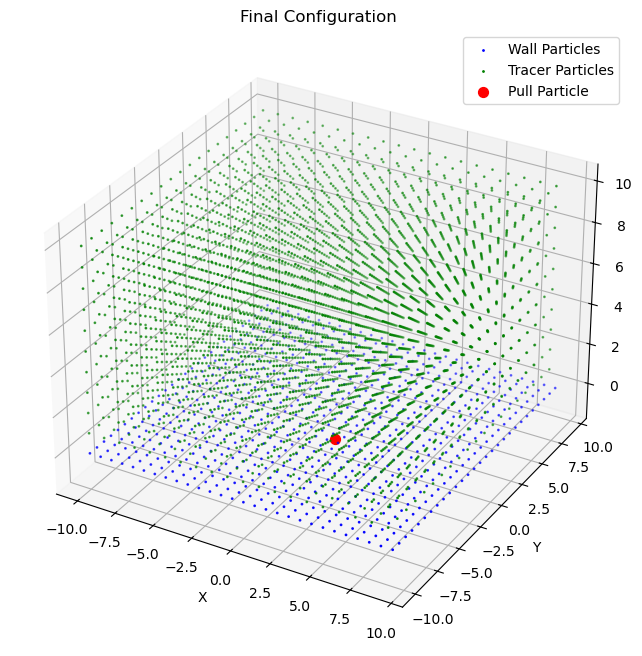

In [ ]:
# Calculate displacements (magnitude of the difference between initial and final positions)
displacements = np.linalg.norm(all_pos - np.vstack((wall_pos, tracers, pull_particle)), axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot particles with displacements as color
scatter = ax.scatter(all_pos[:, 0], all_pos[:, 1], all_pos[:, 2], c=displacements, cmap='viridis', s=1)

# Add color bar to indicate displacement magnitude
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Displacement Magnitude')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Final Configuration with Displacements as Color')
plt.show()
